In [3]:
source("../wwa_model-fitting.R")
source("../00_model-fitting-dev/multivariate/model-fitting_multi-covariate.R")

---
# **Exploratory model fitting**

## **Linear model: spi6 ~ gmst + nino6**

In [2]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
nino34 <- read.csv("ts/nino34_det.csv", col.names = c("date", "nino34"))

# dummy value until December data is available
nino34[nino34$date == "2023-12-15","nino34"] <- nino34[nino34$date == "2023-11-15","nino34"] + mean(nino34[substr(nino34$date,6,7) == "12","nino34"], na.rm = T) - mean(nino34[substr(nino34$date,6,7) == "11","nino34"])

In [17]:
spi <- read.csv("ts/era5_spi6.csv")
nino_mean <- filter(nino34$nino34, rep(1/6,6), sides = 1)

In [18]:
# create data frame with all required variables
df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                         "nino" = nino_mean)[substr(nino34$date,6,7) == "12",])

# fit models: linear model to check significance, and nonstationary model for final
mdl_lm <- lm(spi ~ gmst + nino, df)
mdl_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T)

gmst_2023 <- df$gmst[df$year == 2023]
nino_2023 <- df$nino[df$year == 2023]

In [11]:
# both GMST and Nino3.4 have statistically significant effect (which disappears when we include an interaction)
summary(mdl_lm)


Call:
lm(formula = spi ~ gmst + nino, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3591 -0.5735  0.0743  0.7834  2.5187 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.5013     0.3024   1.658  0.10352   
gmst         -1.9104     0.5661  -3.375  0.00142 **
nino         -0.6028     0.2104  -2.864  0.00605 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.246 on 51 degrees of freedom
Multiple R-squared:  0.2637,	Adjusted R-squared:  0.2348 
F-statistic: 9.133 on 2 and 51 DF,  p-value: 0.0004073


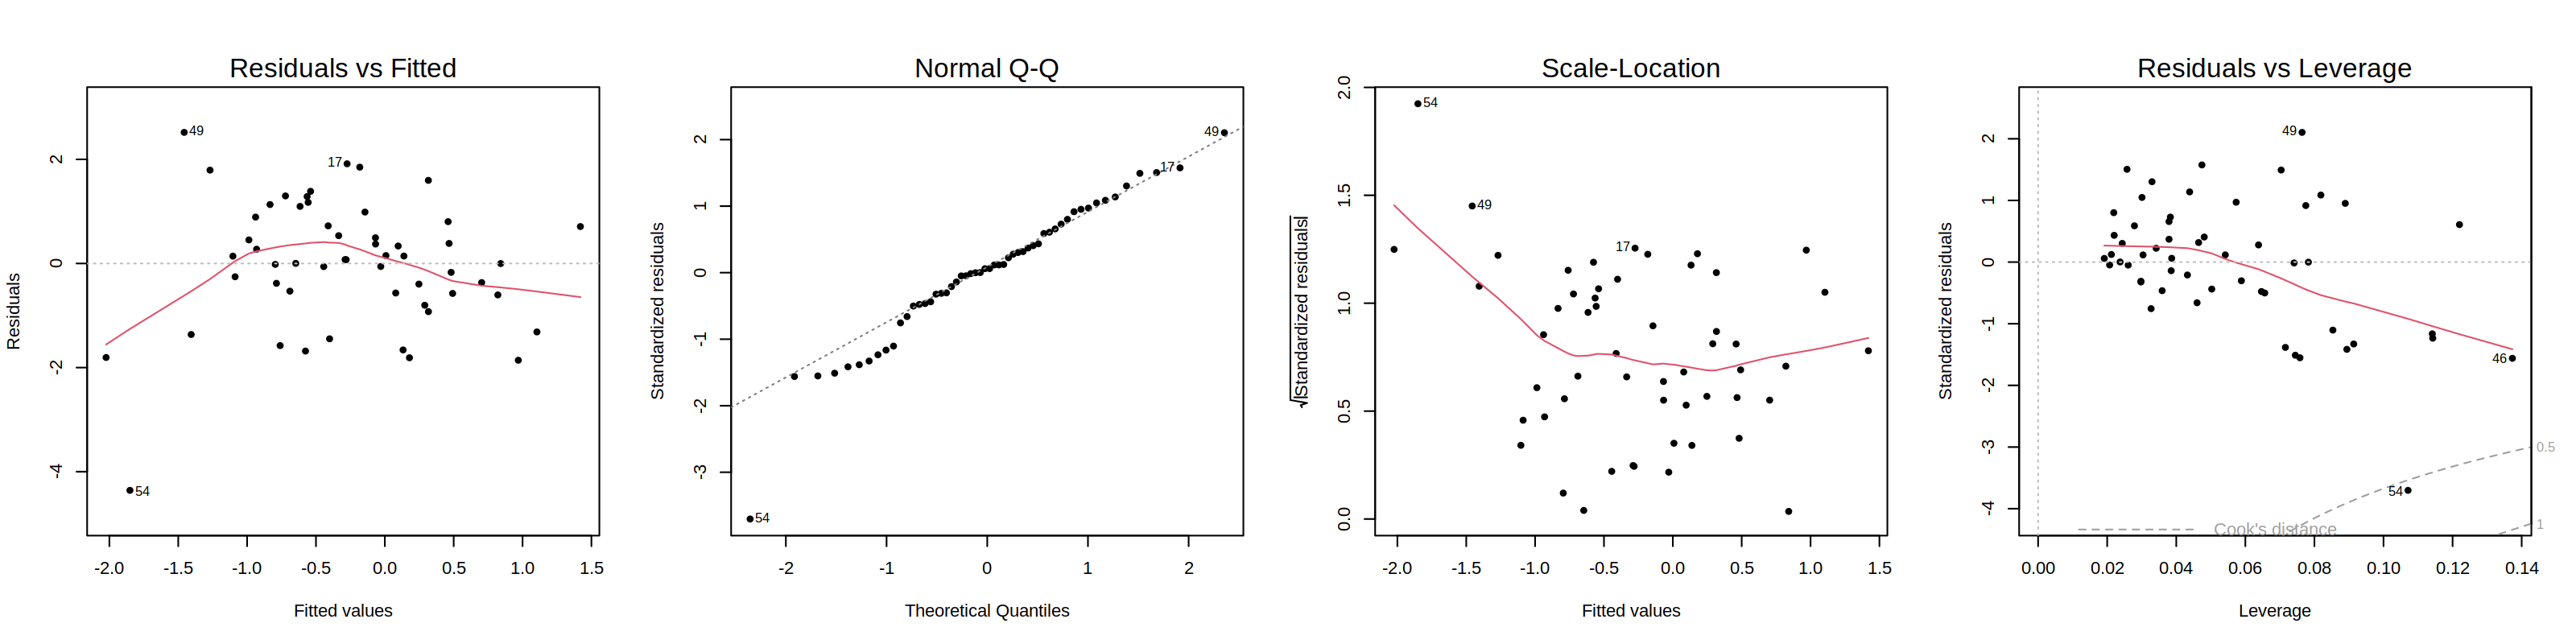

In [13]:
# diagnostic plots using normal linear model

prep_window(c(1,4))
plot(mdl_lm, which = 1)
plot(mdl_lm, which = 2)
plot(mdl_lm, which = 3)
plot(mdl_lm, which = 5)

# 2023 (point 54) has high leverage - try re-fitting without & compare parameters?

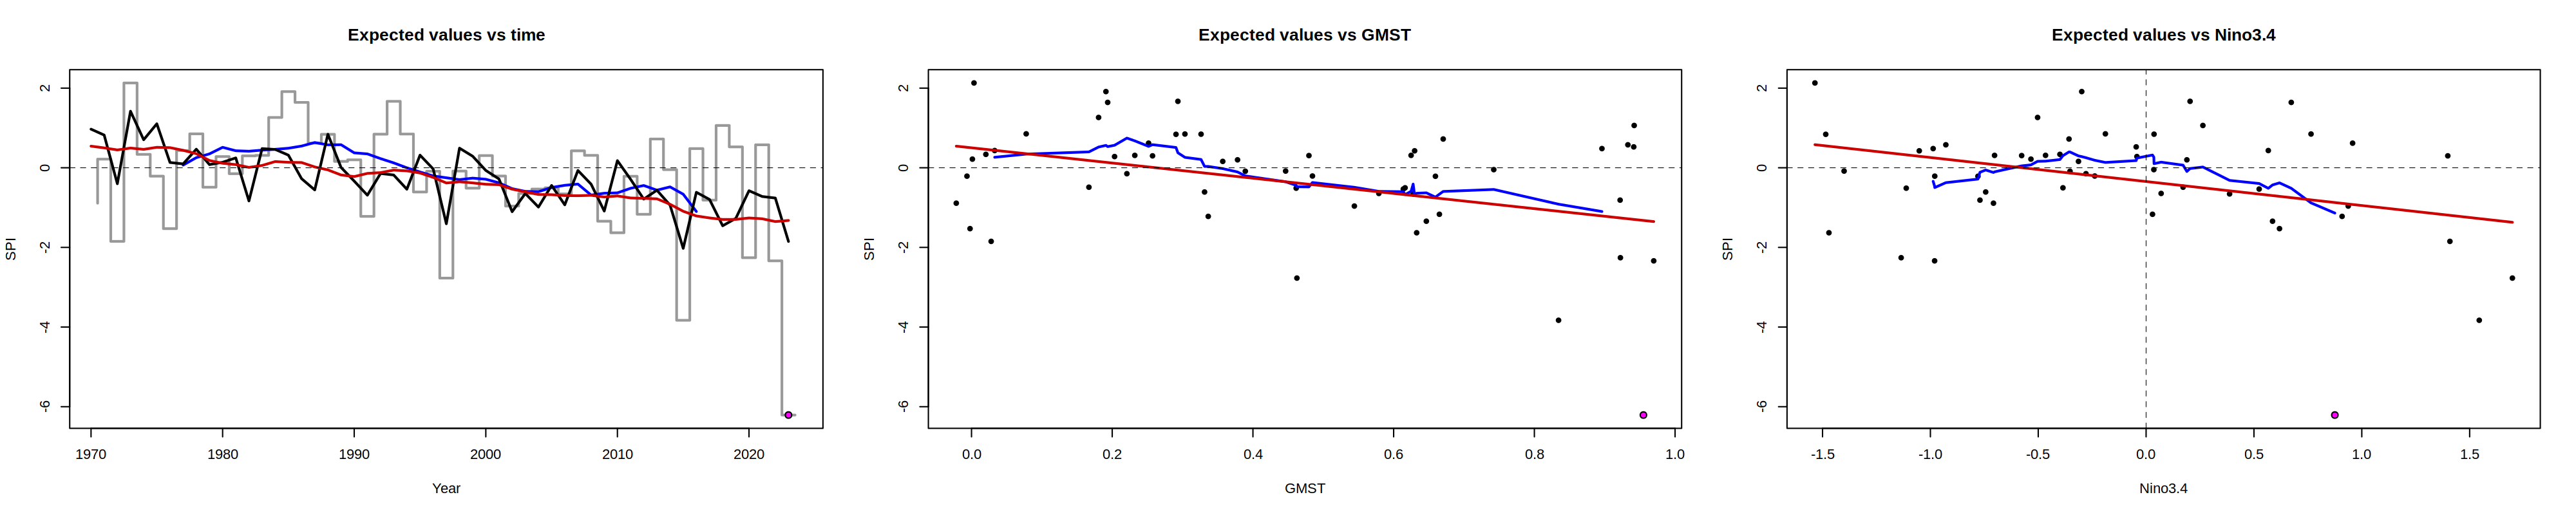

In [14]:
prep_window(c(1,5)); par(mfrow = c(1,3))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year+0.5, df$spi, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "SPI", main = "Expected values vs time")
lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

lines(df$year, ns_pars(mdl_ns)$loc, lwd = 2)
lines(df$year, predict(mdl_lm, newdata = data.frame(gmst = df$gmst, nino = 0)), lwd = 2, col = "red3") # GMST trend
points(df[df$year == 2023,c("year", "spi")], pch = 21, bg = "magenta")

abline(h = 0, lty = 2, lwd = 0.5)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$gmst, df$spi,pch = 20, xlab = "GMST", ylab = "SPI", main = "Expected values vs GMST")
lines(df$gmst[order(df$gmst)], filter(df$spi[order(df$gmst)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

lines(df$gmst[order(df$gmst)], predict(mdl_lm, newdata = data.frame(gmst = sort(df$gmst), nino = 0)), lwd = 2, col = "red3")

abline(h = 0, lty = 2, lwd = 0.5)
points(df[df$year == 2023,c("gmst", "spi")], pch = 21, bg = "magenta")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$nino, df$spi,pch = 20, xlab = "Nino3.4", ylab = "SPI", main = "Expected values vs Nino3.4")
lines(df$nino[order(df$nino)], filter(df$spi[order(df$nino)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

lines(df$nino[order(df$nino)], predict(mdl_lm, newdata = data.frame(gmst = mean(df$gmst), nino = sort(df$nino))), lwd = 2, col = "red3")

abline(h = 0, v = 0, lty = 2, lwd = 0.5)
points(df[df$year == 2023,c("nino", "spi")], pch = 21, bg = "magenta")

---
---
# **Nonstationary model - including Nino**

In [60]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
nino34 <- read.csv("ts/nino34_det.csv", col.names = c("date", "nino34"))

In [61]:
# fit NS model to all time series
models <- list()

for (fnm in list.files("ts", pattern = "cx_.+6.+.csv", full.names = T)) {
    
    # extract all details from filename
    z <- strsplit(fnm, "_")[[1]][2]
    nm <- as.integer(gsub("[a-z]","",z))
    varnm <- gsub("[0-9]","",z)
    ds <- gsub(".csv","",strsplit(fnm,"_")[[1]][3])
    variant <- paste0(varnm,"_nino",nm,"m_",ds)
    lt <- switch(varnm, "pet" = F, "spei" = T, "spi" = T)
    
    # load data & combine into single dataframe
    spi <- read.csv(fnm, col.names = c("year", "spi"))
    nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
    df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                             "nino" = nino_m)[substr(nino34$date,6,7) == "11",])
    # fit model
    mdl <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = lt)
    mdl$variant <- variant
    
    models[[variant]] <- mdl
}

## **Bootstrapped results**

In [5]:
# get results for individual models
for (mdl in models) {
    
    gmst_2023 <- mdl$data$gmst[mdl$data$year == 2023]
    nino_2023 <- mdl$data$nino[mdl$data$year == 2023]
    
    res <- boot_ci(mdl, nsamp = 1000, cov = data.frame(gmst = gmst_2023, nino = 0), cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = 0))
    write.csv(res, paste0("res/res_",mdl$variant,".csv"))
}

In [69]:
# compile into a single spreadsheet
params <- c("alpha_gmst", "alpha_nino", "sigma0", "return_period", "PR", "dI_abs", "event_magnitude")

fl = list.files("res", pattern = "res_.+nino6m", full.names = T)
fl = fl[!grepl("SAM", fl)]

all_res <- t(sapply(fl, function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    res_flattened <- data.frame(c(sapply(params, function(p) res[p,])))
    colnames(res_flattened) <- c(sapply(params, function(p) paste0(p, "_", c("est", "lower", "upper"))))
    res_flattened
}, simplify = T))
# rownames(all_res) <- names(models)[-(1:2)]
write.csv(all_res, "res_obs_incl-nino.csv")

In [67]:
all_res

,alpha_gmst_est,alpha_gmst_lower,alpha_gmst_upper,alpha_nino_est,alpha_nino_lower,alpha_nino_upper,sigma0_est,sigma0_lower,sigma0_upper,return_period_est,⋯,return_period_upper,PR_est,PR_lower,PR_upper,dI_abs_est,dI_abs_lower,dI_abs_upper,event_magnitude_est,event_magnitude_lower,event_magnitude_upper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
res/res_pet_nino6m_era.csv,62.45419,43.88809,80.68781,3.028901,-4.718444,9.016301,15.8156,11.54882,18.6248,5255.792,⋯,50625875,3.414432e+12,534366643,1.325191e+23,74.94503,52.66571,96.82538,785.861,785.861,785.861
res/res_pet_nino6m_ms.csv,82.62429,62.06156,104.4625,1.439038,-5.944212,7.456781,14.25944,10.96243,16.52854,345.5417,⋯,197836.5,2.176134e+19,5.170872e+13,3.234433e+34,99.14914,74.47387,125.355,787.0241,787.0241,787.0241
res/res_spei_nino6m_era.csv,-2.195726,-3.081536,-1.183684,-0.340086,-0.664716,0.0711368,0.9084064,0.7316533,1.008114,104.5373,⋯,2772.614,121422.8,582.9067,2842949259,-2.634872,-3.697843,-1.420421,-3.565667,-3.565667,-3.565667
res/res_spei_nino6m_ms.csv,-1.397511,-2.648208,-0.1531516,-0.3605805,-0.7750712,0.1062007,0.9217368,0.7437719,1.017477,35.84491,⋯,532.4557,293.7532,2.024024,533126,-1.677013,-3.17785,-0.1837819,-2.538018,-2.538018,-2.538018
res/res_spi_nino6m_chirps.csv,-0.6430903,-2.166713,1.074604,-0.7043144,-1.24605,-0.01658904,1.100062,0.7931176,1.262562,494.0349,⋯,2020869,11.5983,0.00349585,38651.75,-0.7717083,-2.600055,1.289524,-3.514359,-3.514359,-3.514359
res/res_spi_nino6m_era.csv,-2.259625,-3.557384,-0.8964049,-0.5172818,-0.9491756,0.02212653,1.120864,0.7940508,1.368968,61058.07,⋯,56759857059,662343,1186.467,164633141398,-2.711549,-4.26886,-1.075686,-6.201154,-6.201154,-6.201154
res/res_spi_nino6m_mswep.csv,-0.4840425,-1.8595,0.9006221,-0.5924217,-1.091586,0.002732779,1.0138,0.7639174,1.14555,369.3262,⋯,235432.1,6.803016,0.01040671,4084.952,-0.580851,-2.2314,1.080747,-3.106389,-3.106389,-3.106389


## **Trend plots**

In [190]:
for (mdl_ns in models) {
    
    df <- mdl_ns$data
    gmst_2023 <- df$gmst[df$year == 2023]
    nino_2023 <- df$nino[df$year == 2023]
    
    gmst_cf <- mean(df$gmst)
    nino_cf <- mean(df$nino)
    
    ylims <- switch(strsplit(mdl_ns$variant, "_")[[1]][1], "spei" = c(-4,2.5), "spi" = c(-6.5,3), "pet" = c(550,800))
        
    png(paste0("fig/trendplots_",mdl_ns$variant,".png"), height = 480 * 0.6, width = 480 * 3); par(cex.main = 1.7, cex.axis = 1.4, cex.lab = 1.4); {

        par(mfrow = c(1,3))
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        plot(df$year+0.5, df$spi, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "SPI", main = "Expected values vs time", ylim = ylims)
        lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

        lines(df$year, ns_pars(mdl_ns)$loc, lwd = 2)
        lines(df$year, ns_pars(mdl_ns, fixed_cov = data.frame(gmst = df$gmst, nino = nino_cf))$loc, lwd = 2, col = "red3") # GMST trend
        points(df[df$year == 2023,c("year", "spi")], pch = 21, bg = "magenta", cex = 2)

        abline(h = 0, lty = 2, lwd = 0.5)
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        plot(df$gmst, df$spi,pch = 20, xlab = "GMST", ylab = "SPI", main = "Expected values vs GMST", ylim = ylims, cex = 1.5)
        lines(df$gmst[order(df$gmst)], filter(df$spi[order(df$gmst)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

        lines(df$gmst[order(df$gmst)], ns_pars(mdl_ns, fixed_cov = data.frame(gmst = sort(df$gmst), nino = nino_cf))$loc, lwd = 2, col = "red3")

        abline(h = 0, lty = 2, lwd = 0.5)
        points(df[df$year == 2023,c("gmst", "spi")], pch = 21, bg = "magenta", cex = 2)
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        plot(df$nino, df$spi,pch = 20, xlab = "Nino3.4", ylab = "SPI", main = "Expected values vs Nino3.4", ylim = ylims)
        lines(df$nino[order(df$nino)], filter(df$spi[order(df$nino)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

        lines(df$nino[order(df$nino)], ns_pars(mdl_ns, fixed_cov = data.frame(gmst = gmst_cf, nino = sort(df$nino)))$loc, lwd = 2, col = "red3")

        abline(h = 0, v = 0, lty = 2, lwd = 0.5)
        points(df[df$year == 2023,c("nino", "spi")], pch = 21, bg = "magenta", cex = 2)

    }; dev.off()
}

## **Return level plots**

In [8]:
for (mdl_ns in models) {
    
    df <- mdl_ns$data
    gmst_2023 <- df$gmst[df$year == 2023]
    nino_2023 <- df$nino[df$year == 2023]
    
    ylims <- switch(strsplit(mdl_ns$variant, "_")[[1]][1],
                    "pet" = c(550,800),
                    "spei" = c(-5,3),
                    "spi" = c(-8,4))
        
    png(paste0("fig/rlplot_",mdl_ns$variant,".png"), height = 480 * 1, width = 480 * 1.5); par(cex.main = 1.4); {

        plot_returnlevels(mdl_ns, cov = data.frame(gmst = gmst_2023, nino = nino_2023), cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = nino_2023), ylim = ylims,
                          main = toupper(paste0(strsplit(mdl_ns$variant, "_")[[1]][3], " ", strsplit(mdl_ns$variant, "_")[[1]][1], " ~ GMST + ",strsplit(mdl_ns$variant, "_")[[1]][2])))
    }; dev.off()
}

## **Change in intensity due to El Nino**

In [ ]:
# # get results for individual models
# nino_change_abs <- list()
# nino_change_rel <- list()

# for (mdl in models) {
    
#     gmst_2023 <- mdl$data$gmst[mdl$data$year == 2023]
#     nino_2023 <- mdl$data$nino[mdl$data$year == 2023]
    
#     res <- boot_ci(mdl, nsamp = 1000, cov = data.frame(gmst = gmst_2023, nino = nino_2023), cov_cf = data.frame(gmst = gmst_2023, nino = 0))
#     nino_change_abs[[mdl$variant]] <- res["dI_abs",]
#     nino_change_rel[[mdl$variant]] <- res["dI_rel",]
# }
# nino_change_abs <- do.call("rbind",nino_change_abs)
# nino_change_rel <- do.call("rbind",nino_change_rel)

# write.csv(nino_change_abs, "res/nino-change_abs.csv")
# write.csv(nino_change_rel, "res/nino-change_rel.csv")

In [54]:
nino_change_abs <- read.csv("res/nino-change_abs.csv", row.names = "X")
nino_change_rel <- read.csv("res/nino-change_rel.csv", row.names = "X")

In [160]:
nino_change_abs

,bestimate,X2.5.,X97.5.
,<dbl>,<dbl>,<dbl>
pet_nino6m_era,2.0517456,-3.1962238,6.107547262
pet_nino6m_ms,0.9747890,-4.0265466,5.051144450
spei_nino6m_era,-0.2303707,-0.4502716,0.048187316
spei_nino6m_ms,-0.2442534,-0.5250251,0.071939234
spi_nino6m_chirps,-0.4770951,-0.8440608,-0.011237243
spi_nino6m_era,-0.3504012,-0.6429615,0.014988277
spi_nino6m_mswep,-0.4013002,-0.7394288,0.001851156


## **Trend with return periods**

In [211]:
prep_window(c(1,3))

n <- length(models_withnino)
ylims <- switch(varnm, "spei" = c(-4,2.5), "spi" = c(-6.5,3))

png(paste0("fig/",varnm,"-trend-with-return-periods.png"), height = 480 * 0.75, width = 480 * n); par(cex.main = 1.7, cex.axis = 1.4, cex.lab = 1.7); {
    par(mfrow = c(1,n), mar = c(3,4.5,3,1))
    for ( ds in names(models_withnino) ) {
    
    mdl_gmst <- models_gmstonly[[ds]]
    df <- mdl_gmst$data
    
    plot(df$year+0.5, df$spi, type = "S", lwd = 3, col = adjustcolor("black", 0.4), xlab = "", ylab = toupper(varnm), main = toupper(ds), ylim = ylims)
    lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

    lines(df$year, ns_pars(mdl_gmst)$loc, lwd = 3)
    lines(df$year, ns_pars(mdl_gmst, fixed_cov = data.frame(gmst = df$gmst))$loc, lwd = 2, col = "black") # GMST trend
        
    lines(df$year, eff_return_level(mdl_gmst, 6), lwd = 2, col = adjustcolor("black", 0.7), lty = 3)
    lines(df$year, eff_return_level(mdl_gmst, 40), lwd = 2, col = adjustcolor("black", 0.4), lty = 3)

    points(df[df$year == 2023,c("year", "spi")], pch = 21, bg = "magenta", cex = 2)

    abline(h = 0, lty = 2, lwd = 0.5)
        
    legend("bottomleft", legend = c("Mean", "1-in-6-year event", "1-in-40-year event"), col = mapply(adjustcolor, "black", c(1,0.7,0.4)), lty = c(1,3,3), lwd = c(3,2,2) , bty = "n", cex = 1.5)
    }
}; dev.off()

png 
  2

In [106]:
par(mfrow = c(1,3), oma = c(0,0,2,0))

png("fig/nino-change-abs.png", height = 480, width = 480); par(cex.main = 1.4); {
    par(mfrow = c(1,3), oma = c(0,0,2,0))
    for ( varnm in c("pet", "spi", "spei") ) {
        bool <- grepl(varnm, rownames(nino_change_abs))
        plot(0, type = "n", xlim = c(0.5,sum(bool)+0.5), ylim = range(pretty(unlist(nino_change_abs[bool,2:3]))), main = toupper(varnm), xaxt = "n", xlab = "", ylab = "")
        axis(1, at = 1:sum(bool), toupper(sapply(strsplit(rownames(nino_change_abs)[bool], "_"), "[", 3)))
        segments(x0 = 1:sum(bool), y0 = nino_change_abs[bool,2], y1 = nino_change_abs[bool,3], lwd = 5, col = adjustcolor("red", alpha = 0.5))
        abline(h = 0, lty = 2)
    }
    mtext("Absolute change due to 2023 El Nino", outer = T, font = 2)
}; dev.off()

png("fig/nino-change-rel.png", height = 480, width = 480); par(cex.main = 1.4); {
    par(mfrow = c(1,3), oma = c(0,0,2,0))
    for ( varnm in c("pet", "spi", "spei") ) {
        bool <- grepl(varnm, rownames(nino_change_rel))
        plot(0, type = "n", xlim = c(0.5,sum(bool)+0.5), ylim = range(pretty(unlist(nino_change_rel[bool,2:3]))), main = toupper(varnm), xaxt = "n", xlab = "", ylab = "")
        axis(1, at = 1:sum(bool), toupper(sapply(strsplit(rownames(nino_change_rel)[bool], "_"), "[", 3)))
        segments(x0 = 1:sum(bool), y0 = nino_change_rel[bool,2], y1 = nino_change_rel[bool,3], lwd = 5, col = adjustcolor("red", alpha = 0.5))
        abline(h = 0, lty = 2)
    }
    mtext("Relative (%) change due to 2023 El Nino", outer = T, font = 2)
}; dev.off()

### **MSWEP: Nino vs GMST change in intensity**

In [171]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
spei <- read.csv("ts/cx_spei6_ms.csv", col.names = c("year", "spei"))

nino34 <- read.csv("ts/nino34_det.csv", col.names = c("year", "nino"))
nino34$nino <- filter(nino34$nino, rep(1/nm,nm), sides = 1)
nino34 <- nino34[substr(nino34$year,6,7) == "11",]
nino34$year <- substr(nino34$year,1,4)

df <- merge(merge(gmst, nino34), spei)

gmst_2023 <- df$gmst[df$year == 2023]
nino_2023 <- df$nino[df$year == 2023]

In [172]:
mdl <- fit_ns("norm", type = "shift", data = df, varnm = "spei", covnm = c("gmst", "nino"), lower = T)

In [173]:
eff_gmst <- boot_ci(mdl, nsamp = 500, cov = data.frame(gmst = gmst_2023, nino = 0), cov_cf = data.frame(gmst = gmst_2023-1.2, nino = 0))
eff_nino <- boot_ci(mdl, nsamp = 500, cov = data.frame(gmst = gmst_2023, nino = nino_2023), cov_cf = data.frame(gmst = gmst_2023, nino = 0))

In [176]:
rbind("gmst" = eff_gmst["dI_abs",], "nino" = eff_nino["dI_abs",])

,bestimate,2.5%,97.5%
gmst,-1.6770132,-3.5414136,-0.1645059809
nino,-0.2442534,-0.5935419,-0.0009408746


---
---
# **Nonstationary model - GMST only**

In [9]:
# fit NS model to all time series
models <- list()

for (fnm in list.files("ts", pattern = "cx_.+6.+.csv", full.names = T)) {
    
    # extract all details from filename
    z <- strsplit(fnm, "_")[[1]][2]
    nm <- as.integer(gsub("[a-z]","",z))
    varnm <- gsub("[0-9]","",z)
    ds <- gsub(".csv","",strsplit(fnm,"_")[[1]][3])
    variant <- paste0(varnm,"_gmst-only_",ds)
    
    # load data & combine into single dataframe
    spi <- read.csv(fnm, col.names = c("year", "spi"))
    df <- merge(spi, gmst)
    
    # fit model
    lt <- switch(varnm, "pet" = F, "spei" = T, "spi" = T)
    mdl <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst"), lower = lt)
    mdl$variant <- variant
    
    models[[variant]] <- mdl
}

## **Bootstrapped results**

In [10]:
# get results for individual models
for (mdl in models) {
    
    gmst_2023 <- mdl$data$gmst[mdl$data$year == 2023]
    
    res <- boot_ci(mdl, nsamp = 1000, cov = data.frame(gmst = gmst_2023), cov_cf = data.frame(gmst = gmst_2023 - 1.2))
    write.csv(res, paste0("res/res_",mdl$variant,".csv"))
}

In [11]:
# compile into a single spreadsheet
params <- c("alpha_gmst", "alpha_nino", "sigma0", "return_period", "PR", "dI_abs", "event_magnitude")

fl = list.files("res", pattern = "res_.+gmst-only", full.names = T)
fl = fl[!grepl("SAM", fl)]

all_res <- t(sapply(fl, function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    res_flattened <- data.frame(c(sapply(params, function(p) res[p,])))
    colnames(res_flattened) <- c(sapply(params, function(p) paste0(p, "_", c("est", "lower", "upper"))))
    res_flattened
}, simplify = T))
rownames(all_res) <- names(models)
write.csv(all_res, "res-gmst-only.csv")

## **Trend plots**

In [12]:
for (mdl_ns in models) {
    
    df <- mdl_ns$data
    gmst_2023 <- df$gmst[df$year == 2023]
            
    png(paste0("fig/trendplots_",mdl_ns$variant,".png"), height = 480 * 1, width = 480 * 3); par(cex.main = 1.4); {

        par(mfrow = c(1,2))
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        plot(df$year+0.5, df$spi, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "SPI", main = "Expected values vs time")
        lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)
    
        lines(df$year, eff_return_level(mdl_ns, 6), lty = 2, col = adjustcolor("black", 0.7))
        lines(df$year, eff_return_level(mdl_ns, 40), lty = 2, col = adjustcolor("black", 0.3))

        lines(df$year, ns_pars(mdl_ns)$loc, lwd = 2)
        points(df[df$year == 2023,c("year", "spi")], pch = 21, bg = "magenta")

        abline(h = 0, lty = 2, lwd = 0.5)
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        df_o <- df[order(df$gmst),]
        plot(df_o$gmst, df_o$spi,pch = 20, xlab = "GMST", ylab = "SPI", main = "Expected values vs GMST")
        lines(df_o$gmst, filter(df_o$spi[order(df$gmst)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

        lines(df_o$gmst, ns_pars(mdl_ns)$loc[order(df$gmst)], lwd = 2, col = "black")
        lines(df_o$gmst, eff_return_level(mdl_ns, 6)[order(df$gmst)], lty = 2, col = adjustcolor("black", 0.7))
        lines(df_o$gmst, eff_return_level(mdl_ns, 40)[order(df$gmst)], lty = 2, col = adjustcolor("black", 0.3))

        abline(h = 0, lty = 2, lwd = 0.5)
        points(df[df$year == 2023,c("gmst", "spi")], pch = 21, bg = "magenta")

    }; dev.off()
}

## **Return level plots**

In [13]:
for (mdl_ns in models) {
    
    df <- mdl_ns$data
    gmst_2023 <- df$gmst[df$year == 2023]
    nino_2023 <- df$nino[df$year == 2023]
    
    ylims <- switch(strsplit(mdl_ns$variant, "_")[[1]][1],
                    "pet" = c(550,800),
                    "spei" = c(-5,3),
                    "spi" = c(-8,4))
        
    png(paste0("fig/rlplot_",mdl_ns$variant,".png"), height = 480 * 1, width = 480 * 1.5); par(cex.main = 1.4); {

        plot_returnlevels(mdl_ns, cov = data.frame(gmst = gmst_2023), cov_cf = data.frame(gmst = gmst_2023 - 1.2), ylim = ylims,
                          main = toupper(paste0(strsplit(mdl_ns$variant, "_")[[1]][2], " ", strsplit(mdl_ns$variant, "_")[[1]][1], " ~ GMST")))
    }; dev.off()
}

---
---
# **Earlier noodlings**

### **Trend excluding 2023**

In [47]:
for (varnm in c("spi", "spei")) {
    for (nm in c(6,24)) {
        
        # load data & compile into single dataframe
        spi <- read.csv(paste0("ts/era5_",varnm,nm,".csv"), col.names = c("year", "spi"))
        nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
        df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                                 "nino" = nino_m)[substr(nino34$date,6,7) == "12",])
        df_2023 <- df[df$year == 2023,]
        gmst_2023 <- df_2023$gmst
        nino_2023 <- df_2023$nino
        
        # remove 2023 from model fit
        df <- df[df$year < 2023,]
        
        # fit model
        mdl_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T)
        
        png(paste0("fig/trendplots-excl2023_era5_",varnm,nm,".png"), height = 480, width = 480 * 5); par(cex.main = 1.4); {

            par(mfrow = c(1,3))
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            plot(df$year+0.5, df$spi, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "SPI", main = "Expected values vs time")
            lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

            lines(df$year, ns_pars(mdl_ns)$loc, lwd = 2)
            lines(df$year, ns_pars(mdl_ns, fixed_cov = data.frame(gmst = df$gmst, nino = 0))$loc, lwd = 2, col = "red3") # GMST trend
            points(df_2023[,c("year", "spi")], pch = 21, bg = "magenta")

            abline(h = 0, lty = 2, lwd = 0.5)
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            plot(df$gmst, df$spi,pch = 20, xlab = "GMST", ylab = "SPI", main = "Expected values vs GMST")
            lines(df$gmst[order(df$gmst)], filter(df$spi[order(df$gmst)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

            lines(df$gmst[order(df$gmst)], ns_pars(mdl_ns, fixed_cov = data.frame(gmst = sort(df$gmst), nino = 0))$loc, lwd = 2, col = "red3")

            abline(h = 0, lty = 2, lwd = 0.5)
            points(df_2023[,c("gmst", "spi")], pch = 21, bg = "magenta")
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            plot(df$nino, df$spi,pch = 20, xlab = "Nino3.4", ylab = "SPI", main = "Expected values vs Nino3.4")
            lines(df$nino[order(df$nino)], filter(df$spi[order(df$nino)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

            lines(df$nino[order(df$nino)], ns_pars(mdl_ns, fixed_cov = data.frame(gmst = mean(df$gmst), nino = sort(df$nino)))$loc, lwd = 2, col = "red3")

            abline(h = 0, v = 0, lty = 2, lwd = 0.5)
            points(df_2023[,c("nino", "spi")], pch = 21, bg = "magenta")
            
        }; dev.off()
    }
}

## **Sensitivity to 2023 observation**

In [98]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
nino34 <- read.csv("ts/nino34_det.csv", col.names = c("date", "nino34"))
nino34[nino34$date == "2023-12-15","nino34"] <- nino34[nino34$date == "2023-11-15","nino34"] # dummy value until December data is available

In [55]:
for (varnm in c("spi", "spei")) {
    for (nm in c(6,24)) {
        
        # load data & compile into single dataframe
        spi <- read.csv(paste0("ts/era5_",varnm,nm,".csv"), col.names = c("year", "spi"))
        nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
        df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                                 "nino" = nino_m)[substr(nino34$date,6,7) == "12",])
        
        # fit model and get fixed covariates
        mdl_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T)
        gmst_2023 <- df$gmst[df$year == 2023]
        nino_2023 <- df$nino[df$year == 2023]
        
        png(paste0("fig/loo-sensitivity_era5_",varnm,nm,".png"), height = 480, width = 480 * 2); par(cex.main = 1.4); {
            loo_pars(mdl_ns, cov = data.frame(gmst = gmst_2023, nino = 0), cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = 0), plot = T, relative = F)
        }; dev.off()
    }
}

### **Bootstrapped results with & without 2023**

In [75]:
nsamp <- 1000
for (varnm in c("spi", "spei")) {
    for (nm in c(6,24)) {
        
        # load data & compile into single dataframe
        spi <- read.csv(paste0("ts/era5_",varnm,nm,".csv"), col.names = c("year", "spi"))
        nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
        df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                                 "nino" = nino_m)[substr(nino34$date,6,7) == "12",])
        df_2023 <- df[df$year == 2023,]
        gmst_2023 <- df_2023$gmst
        nino_2023 <- df_2023$nino
        ev_2023 <- df_2023$spi
        
        # fit standard model & write bootstrapped results to csv
        mdl_incl <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T, ev = ev_2023)
        res_incl <- boot_ci(mdl_incl, nsamp = nsamp, cov = data.frame(gmst = gmst_2023, nino = 0), cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = 0))
        write.csv(res_incl, paste0("res/res-incl2023_era5_",varnm,nm,".csv"))
        
        # remove 2023 from model fit & write bootstrapped results to csv
        df <- df[df$year < 2023,]
        mdl_excl <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T, ev = ev_2023)
        res_excl <- boot_ci(mdl_excl, nsamp = nsamp, cov = data.frame(gmst = gmst_2023, nino = 0), cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = 0))
        write.csv(res_excl, paste0("res/res-excl2023_era5_",varnm,nm,".csv"))
        
        res <- abind(res_incl, res_excl, along = 0)
        
        png(paste0("fig/ns-params_era5_",varnm,nm,".png"), height = 480, width = 480 * 2); par(mfrow = c(1,8), mar = c(3,3,3,1), cex.main = 1.6); {
            for (i in rownames(res_incl)[-c(5,6)]) {
                if(i == "PR") {
                    x <- 1
                } else if (!(i %in% c("sigma0", "mu0"))) {
                    x <- 0
                } else {
                    x <- NA
                }
                plot(0, type = "n", ylim = range(c(res[,i,], x), na.rm = T), xlab = "", ylab = "", main = i, xaxt = "n")
                axis(1, at = c(0.8, 1.2), labels = c("Incl", "Excl"), las = 2)
                segments(x0 = c(0.8, 1.2), y0 = res[,i,2], y1 = res[,i,3], col = adjustcolor(c("red3", "blue3"), alpha = 0.4), lwd = 5)
                points(c(0.8, 1.2), res[,i,1], pch = 21, bg = c("red3", "blue3"))
                abline(h = x, lty = 2)
            } 
        }; dev.off()
    }
}

## **Shape of MSWEP/CHIRPS distribution**


	Exact one-sample Kolmogorov-Smirnov test

data:  scale(df$spi)
D = 0.12328, p-value = 0.4923
alternative hypothesis: two-sided


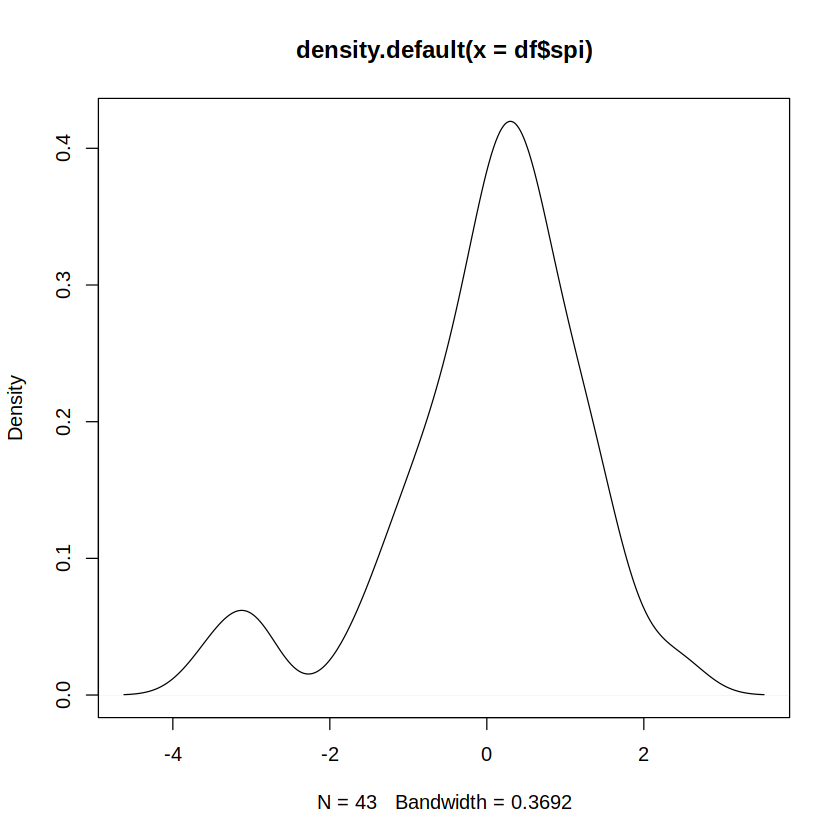

In [33]:
df <- read.csv("ts/cx_spi6_chirps.csv")

# could plausibly be a mixture - don't think a transformation is going to fix this, anyway
plot(density(df$spi))

ks.test(scale(df$spi), pnorm)

---
# **GMST trend parameters excluding ENSO?**

In [3]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))

In [28]:
# fit NS model to all time series
models_excl_nino <- list()

for (fnm in list.files("ts", pattern = "cx.+.csv", full.names = T)) {
    
    # extract all details from filename
    z <- strsplit(fnm, "_")[[1]][2]
    nm <- as.integer(gsub("[a-z]","",z))
    varnm <- gsub("[0-9]","",z)
    ds <- gsub(".csv","",strsplit(fnm,"_")[[1]][3])
    variant <- paste0(varnm,"_nino",nm,"m_",ds)
    
    # load data & combine into single dataframe
    spi <- read.csv(fnm, col.names = c("year", "spi"))
    df <- merge(spi, gmst)
    
    # fit model
    mdl <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst"), lower = T)
    mdl$variant <- variant
    
    models_excl_nino[[variant]] <- mdl
}

In [34]:
# get results for individual models
for (mdl in models_excl_nino) {
    
    gmst_2023 <- mdl$data$gmst[mdl$data$year == 2023]
    
    res <- boot_ci(mdl, nsamp = 1000, cov = data.frame(gmst = gmst_2023), cov_cf = data.frame(gmst = gmst_2023 - 1.2))
    write.csv(res, paste0("res/res-excl-nino_",mdl$variant,".csv"))
}

In [35]:
# compile into a single spreadsheet
params <- c("alpha_gmst", "alpha_nino", "sigma0", "return_period", "PR", "dI_abs")
res_x <- t(sapply(list.files("res", pattern = "res-excl-nino_", full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    setNames(c(sapply(params, function(p) res[p,])), c(sapply(params, function(p) paste0(p, "_", c("est", "lower", "upper")))))
}, simplify = T))

rownames(res_x) <- names(models)

alpha_gmst_est alpha_gmst_lower alpha_gmst_upper
spei_nino24m_era   -1.568074      -2.602418        -0.5936708      
spei_nino24m_ms    -0.6006237     -1.899055        0.6972444       
spei_nino6m_era    -2.141254      -3.128494        -1.118851       
spei_nino6m_ms     -1.244381      -2.526429        -0.05718456     
spi_nino24m_chirps 2.450801       1.128482         3.941522        
spi_nino24m_era    -0.6970861     -1.619151        0.1513634       
spi_nino24m_mswep  1.273383       -0.06544794      2.643185        
spi_nino6m_chirps  -0.3428327     -2.007184        1.312155        
spi_nino6m_era     -2.177745      -3.611893        -0.7955072      
spi_nino6m_mswep   -0.2317309     -1.762763        1.130776        
                   alpha_nino_est alpha_nino_lower alpha_nino_upper sigma0_est
spei_nino24m_era   NA             NA               NA               0.9642061 
spei_nino24m_ms    NA             NA               NA               1.049042  
spei_nino6m_era    NA             NA               NA               0.9409455 
spei_nino6m_ms     NA             NA               NA               0.9561796 
spi_nino24m_chirps NA             NA               NA               1.039889  
spi_nino24m_era    NA             NA               NA               0.909862  
spi_nino24m_mswep  NA             NA               NA               1.079489  
spi_nino6m_chirps  NA             NA               NA               1.211277  
spi_nino6m_era     NA             NA               NA               1.181269  
spi_nino6m_mswep   NA             NA               NA               1.096176  
                   sigma0_lower sigma0_upper return_period_est
spei_nino24m_era   0.7644062    1.145262     1027.922         
spei_nino24m_ms    0.8481597    1.196688     2.026469         
spei_nino6m_era    0.7531707    1.05136      107.149          
spei_nino6m_ms     0.7734024    1.081184     40.83412         
spi_nino24m_chirps 0.7736633    1.243896     2.606714         
spi_nino24m_era    0.7365278    1.055911     258.8067         
spi_nino24m_mswep  0.8484319    1.251781     2.348135         
spi_nino6m_chirps  0.8125916    1.475746     395.6768         
spi_nino6m_era     0.8187849    1.476399     39036.9          
spi_nino6m_mswep   0.8027235    1.330008     337.3165         
                   return_period_lower return_period_upper PR_est   
spei_nino24m_era   75.13904            129997.9            4402.569 
spei_nino24m_ms    1.386158            4.040091            2.048478 
spei_nino6m_era    26.98958            2854.119            50218.05 
spei_nino6m_ms     9.956034            568.731             118.0709 
spi_nino24m_chirps 1.614346            6.179244            0.3858115
spi_nino24m_era    36.3813             7923.155            22.76053 
spi_nino24m_mswep  1.456981            5.738345            0.4782922
spi_nino6m_chirps  31.79587            1835715             3.024419 
spi_nino6m_era     372.1862            28095565017         134976.9 
spi_nino6m_mswep   30.73914            148748.8            2.235117 
                   PR_lower    PR_upper    dI_abs_est dI_abs_lower dI_abs_upper
spei_nino24m_era   41.22696    7005177     -1.881688  -3.122902    -0.712405   
spei_nino24m_ms    0.4541804   17.76873    -0.7207484 -2.278866    0.8366932   
spei_nino6m_era    266.0135    456069628   -2.569505  -3.754192    -1.342621   
spei_nino6m_ms     1.254226    104820.4    -1.493257  -3.031715    -0.06862147 
spi_nino24m_chirps 0.1618501   0.6514609   2.940961   1.354178     4.729826    
spi_nino24m_era    0.4660455   2011.123    -0.8365033 -1.942981    0.1816361   
spi_nino24m_mswep  0.1772704   1.046014    1.528059   -0.07853753  3.171823    
spi_nino6m_chirps  0.00187882  924.3962    -0.4113993 -2.408621    1.574586    
spi_nino6m_era     289.5438    17444761076 -2.613294  -4.334271    -0.9546086  
spi_nino6m_mswep   0.005353531 741.9164    -0.278077  -2.115316    1.356931

In [86]:
prep_window(c(1,4)); par(mfrow = c(1,10), mar = c(3,3,3,1))

varnm = "alpha_gmst"

res_with <- res_x[,grepl(varnm, colnames(res_x))]
res_without <- all_res[,grepl(varnm, colnames(all_res))]

png(paste0("fig/gmst-params_with-and-without-enso.png"), height = 480, width = 480 * 3); par(mfrow = c(1,10), mar = c(3,3,3,1), cex.main = 1.6); {
    for (i in rownames(res_x)) {
        plot(0, type = "n", ylim = range(c(res_with, res_without), na.rm = T), xlab = "", ylab = "", main = i, xaxt = "n")
        axis(1, at = c(0.8, 1.2), labels = c("GMST\nonly", "GMST +\nNino"), las = 1)
        
        lines(rep(0.8, 2), res_without[i,2:3], col = adjustcolor("blue", alpha = 0.4), lwd = 7)
        points(0.8, res_without[i,1], pch = 21, bg = c("blue"), cex = 1.4)
        
        lines(rep(1.2, 2), res_with[i,2:3], col = adjustcolor("red3", alpha = 0.4), lwd = 7)
        points(1.2, res_with[i,1], pch = 21, bg = c("red3"), cex = 1.4)
        
        abline(h = 0, lty = 2)
    } 
}; dev.off()

png 
  2

---
# **Effect of GMST & ENSO on PET**

In [89]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
nino34 <- read.csv("ts/nino34_det.csv", col.names = c("date", "nino34"))
nino34[nino34$date == "2023-12-15","nino34"] <- nino34[nino34$date == "2023-11-15","nino34"] # dummy value until December data is available

In [114]:
# fit NS model to all time series
pet_models <- list()

for (fnm in list.files("ts", pattern = "cx_pet.+.csv", full.names = T)) {
    
    # extract all details from filename
    z <- strsplit(fnm, "_")[[1]][2]
    nm <- as.integer(gsub("[a-z]","",z))
    varnm <- gsub("[0-9]","",z)
    ds <- gsub(".csv","",strsplit(fnm,"_")[[1]][3])
    variant <- paste0(varnm,"_nino",nm,"m_",ds)
    
    # load data & combine into single dataframe
    pet <- read.csv(fnm, col.names = c("year", "pet"))
    pet <- pet[!is.na(pet$pet),]
    nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
    df <- merge(merge(pet, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                             "nino" = nino_m)[substr(nino34$date,6,7) == "12",])
    # fit model
    mdl <- fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = c("gmst", "nino"), lower = F)
    mdl$variant <- variant
    
    pet_models[[variant]] <- mdl
}

## **Return level plots**

In [116]:
for (mdl_ns in pet_models) {
    
    df <- mdl_ns$data
    gmst_2023 <- df$gmst[df$year == 2023]
    nino_2023 <- df$nino[df$year == 2023]
    
    ylims <- switch(paste0(strsplit(mdl_ns$variant, "_")[[1]][1:2], collapse = "_"),
                    "spei_nino6m" = c(-5,3),
                    "spei_nino24m" = c(-4,4),
                    "spi_nino6m" = c(-8,4),
                    "spi_nino24m" = c(-4,4),
                    "pet_nino6m" = c(550,850),
                    "pet_nino24m" = c(2500,3000))
        
    png(paste0("fig/rlplot_",mdl_ns$variant,".png"), height = 480 * 1, width = 480 * 1.5); par(cex.main = 1.4); {

        plot_returnlevels(mdl_ns, cov = data.frame(gmst = gmst_2023, nino = nino_2023), cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = nino_2023), ylim = ylims,
                          main = toupper(paste0(strsplit(mdl_ns$variant, "_")[[1]][3], " ", strsplit(mdl_ns$variant, "_")[[1]][1], " ~ GMST + ",strsplit(mdl_ns$variant, "_")[[1]][2])))
    }; dev.off()
}

---
---
# **CORDEX**

In [36]:
source("../wwa_model-fitting.R")
source("../00_model-fitting-dev/multivariate/model-fitting_multi-covariate.R")

# method to get bootstrapped model results
cmodel_results <- function(mdl, rp = 10, cov_f, cov_cf, cov_fut, nsamp = 5, seed = 42, di_relative = NA, y_start = 1979, y_now = 2023, y_fut = 2050) {
    
    set.seed(seed)
    
    # fill in missing parameters
    if(is.na(di_relative)) di_relative <- mdl$type == "fixeddisp"
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # FIT MODEL to three different subsets: for evaluation, attribution & projection
    
    df <- mdl$data
    
    # fit models
    mdl_eval <- refit(mdl, new_df = df[df$year >= y_start & df$year <= y_now,])
    mdl_attr <- refit(mdl, new_df = df[df$year <= y_now,])
    mdl_proj <- refit(mdl, new_df = df[df$year <= y_fut,])
    
    # get return level to use for analysis
    event_rl <- eff_return_level(mdl_attr, rp = rp, fixed_cov = cov_f)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## Bootstrap each set of model results
    
    if(di_relative) { di_cnm <- "dI_rel" } else { di_cnm <- "dI_abs" }
    if(mdl$type == "fixeddisp") { key_par <- "disp" } else { key_par <- "sigma0" }
    if(mdl$dist == "gev") { key_par <- c(key_par, "shape") }
    
    ci_eval <- boot_ci(mdl_eval, cov = cov_f, cov_cf = cov_cf, ev = event_rl, rp = rp, nsamp = nsamp)[c(key_par),,drop = F]
    ci_attr <- boot_ci(mdl_attr, cov = cov_f, cov_cf = cov_cf, ev = event_rl, rp = rp, nsamp = nsamp)[c("PR", di_cnm),]
    ci_proj <- boot_ci(mdl_proj, cov = cov_f, cov_cf = cov_fut, ev = event_rl, rp = rp, nsamp = nsamp)[c("PR", di_cnm),]
                       
    # invert future projections
    ci_proj["PR",] <- 1/ci_proj["PR",c(1,3,2)]
    ci_proj[di_cnm,] <- -ci_proj[di_cnm, c(1,3,2)]
    
    # flatten & rename
    ci_eval <- unlist(lapply(rownames(ci_eval), function(cnm) setNames(ci_eval[cnm,], paste("eval", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
    ci_attr <- unlist(lapply(rownames(ci_attr), function(cnm) setNames(ci_attr[cnm,], paste("attr", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
    ci_proj <- unlist(lapply(rownames(ci_proj), function(cnm) setNames(ci_proj[cnm,], paste("proj", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
                         
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    res <- t(data.frame(c(ci_eval, "rp_value" = event_rl, ci_attr, ci_proj)))     
    rownames(res) <- paste0(mdl$varnm, " ~ ", mdl$covnm_1, " (rp", rp,")")
    return(res)
}

In [85]:
varnm = "spei"

rp <- switch(varnm, "spei" = 50, "spi" = 100)

for ( fnm in list.files("ts", pattern = paste0(varnm,"_SAM"), full.names = T) ) {
    
    print(fnm)
    res_fnm <- paste0("res/res-excl-nino_",gsub("ts/", "", gsub(".dat", "", fnm)), ".csv")
    model_name = paste0(strsplit(fnm, "_")[[1]][2:5], collapse = "_")
    
    # if(!file.exists(res_fnm)) {   # won't replace any files that already exist - have to delete manually first
        
        # identify the correct GMST file
        gmst_fnm <- list.files("ts", paste0("smoothed-gsat_", gsub("i1p1","",paste0(strsplit(fnm, "_")[[1]][3:4], collapse = "_rcp85_")), ".dat"),
                               full.names = T)
        

        # load data & merge into single dataframe
        var <- read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "var"))        
        gmst <- read.csv(gmst_fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst"))
        df <- merge(gmst, var)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # SPECIFY MODEL TO BE ANALYSED
        
        # value of covariate in present/factual climate
        cov_2023 <- df[df$year == 2023, "gmst", drop = F]
        cov_hist <- df[df$year == 2023, "gmst", drop = F] + c(-1.2)
        cov_fut <- df[df$year == 2023, "gmst", drop = F] + c(0.8)
        
        # fit the model - this is used as a template for the attribution
        mdl <- fit_ns("norm", "shift", df, "var", "gmst", lower = T, mintemps = F, event_index = which(df$year == 2023))
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        # trend & return level plots for further validation, if needed
        png(paste0("fig_cordex/mdl-fit_",varnm,"_",model_name,".png"), height = 480, width = 480 * 3); par(cex.main = 1.4); {
            par(mfrow = c(1,2), oma = c(0,0,2,0))

            plot(df$year+0.5, df$var, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = toupper(varnm), main = "Fitted trend in model output")
            lines(df$year, filter(df$var, rep(1/15,15), sides = 2), col = "blue", lwd = 2)
            lines(df$year, ns_pars(mdl)$loc, lwd = 2)
            abline(h = 0, lty = 2, lwd = 0.5)

            # plot(df$gmst, df$var, pch = 20, col = adjustcolor("black", 0.4), xlab = "GMST", ylab = "SPI", main = "Fitted trend in model output")
            # lines(df$gmst[order(df$gmst)], filter(df$var[order(df$gmst)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)
            # lines(df$gmst, ns_pars(mdl)$loc, lwd = 2)

            plot_returnlevels(mdl, cov = cov_2023, cov_cf = cov_hist, main = paste0("Return levels: ",varnm," ~ gmst"), ylab = varnm, ev = NA)

            mtext(model_name, outer = T, font = 2, cex = 1.5)
        }; dev.off()
        
        # get model results & save as .csv
        # res_df <- cmodel_results(mdl, rp = rp, cov_f = cov_2023, cov_cf = cov_hist, cov_fut = cov_fut, nsamp = 1000, y_start = 1950, y_now = 2023, y_fut = 2050)
        # rownames(res_df) <- model_name
        # write.csv(res_df, res_fnm)
    # }
    
}

In [25]:
# compile into a single file
res <- t(sapply(list.files("res", pattern = paste0("res-excl-nino_",varnm,"_SAM"), full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(lapply(strsplit(rownames(res), "_"), "[", 4:6), paste0, collapse = "_")

write.csv(res, paste0("res_",varnm,"6_cordex_gmst-only.csv"))

---
---
# **Joint distribution of PET & PR**

In [5]:
library(copula)
source("../wwa_model-fitting.R")
source("../00_model-fitting-dev/multivariate/model-fitting_multi-covariate.R")

# compute joint exceedances over regular grid for easy plotting
copula_mesh <- function(mdl_x, mdl_y, copula, cov1, xrange, yrange, n = 32) {
    
    # compute joint exceedances over regular grid for easy plotting
    
    if(missing(xrange)) xrange <- range(pretty(mdl_x$x))
    if(missing(yrange)) yrange <- range(pretty(mdl_y$x))
    
    # define the regular mesh for plotting
    x_mesh <- seq(xrange[1], xrange[2],length.out = n)
    y_mesh <- seq(yrange[1], yrange[2], length.out = n)
    
    # convert the regular mesh to U space
    x_umesh <- map_to_u(mdl_x, x_mesh, fixed_cov = cov1)
    y_umesh <- map_to_u(mdl_y, y_mesh, fixed_cov = cov1)
    
    if(substr(mdl_x$varnm,1,5) == "log10") { x_mesh <- 10^x_mesh }
    if(substr(mdl_y$varnm,1,5) == "log10") { y_mesh <- 10^y_mesh }
    
    return(list("x" = x_mesh, "y" = y_mesh, "z" = sapply(y_umesh, function(y) sapply(x_umesh, function(x) pCopula(cbind(x,y), copula)))))
}

In [45]:
# load data
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))

nino34 <- read.csv("ts/nino34_det.csv", col.names = c("year", "nino34"))
nino34$nino34 <- filter(nino34$nino34, rep(1/6,6), sides = 1)
nino34 <- nino34[substr(nino34$year,6,7) == "11",]
nino34$year <- substr(nino34$year,1,4)

pet <- read.csv("ts/cx_pet6_ms.csv")
pr <- read.csv("ts/cx_pr6_ms.csv", col.names = c("year", "pr"))

# compile into single dataframe
df <- merge(merge(merge(gmst, nino34), pet), pr)

gmst_2023 <- df$gmst[df$year == 2023]
nino_2023 <- df$nino34[df$year == 2023]

# covariates to define scenarios
cov_2023 <- df[df$year == 2023,c("gmst","nino34")]
cov_hist <- data.frame(gmst = gmst_2023 - 1.2, nino34 = nino_2023)
cov_neut <- data.frame(gmst = gmst_2023, nino34 = 0)
cov_neuthist <- data.frame(gmst = gmst_2023 - 1.2, nino34 = 0)

## **pet, pr ~ gmst + nino**

In [75]:
# fit marginal distributions
mdl_pet <- fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = c("gmst", "nino34"), lower = F)
mdl_pr <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm = c("gmst", "nino34"), lower = T)  
# don't need to specify lower tail with MVDC, since marginals are handled simultaneously

# transform marginals to U
u_pr <- map_to_u(mdl_pr)
u_pet <- map_to_u(mdl_pet)

### **Check copula**

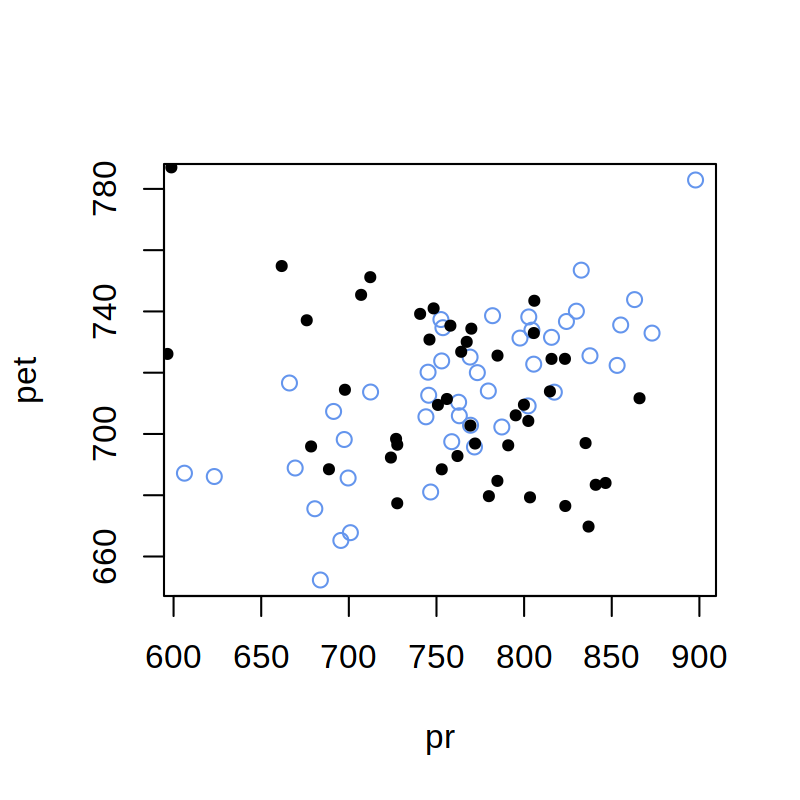

In [76]:
# fit copula to u,v pairs, generate a sample
fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_pet), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting

fitted_mvdc <- mvdc(copula = tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0)), 
                    margins=c("norm", "norm"), paramMargins=list(list(mean=mean(df$pr), sd=sd(df$pr)), list(mean=mean(df$pet), sd=sd(df$pet))))

set.seed(42)
mvsamp <- rMvdc(nrow(df), fitted_mvdc)
colnames(mvsamp) <- c("pr", "pet")

plot(mvsamp, col = "cornflowerblue")
points(df$pr, df$pet, pch = 20, col = "black")

### **Fit chosen model & get contour values**

In [77]:
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))

In [78]:
# get return levels in factual & counterfactual climates
rl_pr <- list("2023" = mdl_pr$ev, 
              "hist" = stransform(mdl_pr, fixed_cov = cov_hist)[df$year == 2023],
              "neut" = stransform(mdl_pr, fixed_cov = cov_neut)[df$year == 2023],
              "neuthist" = stransform(mdl_pr, fixed_cov = cov_neuthist)[df$year == 2023])

rl_pet <- list("2023" = mdl_pet$ev, 
              "hist" = stransform(mdl_pet, fixed_cov = cov_hist)[df$year == 2023],
              "neut" = stransform(mdl_pet, fixed_cov = cov_neut)[df$year == 2023],
              "neuthist" = stransform(mdl_pet, fixed_cov = cov_neuthist)[df$year == 2023])

In [79]:
# joint exceedance probabilities
joint_ep <- list("2023" = 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_2023), map_to_u(mdl_pet, mdl_pet$ev, cov_2023)), cfit),
                 "hist" = 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_hist), map_to_u(mdl_pet, mdl_pet$ev, cov_hist)), cfit),
                 "neut" = 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_neut), map_to_u(mdl_pet, mdl_pet$ev, cov_neut)), cfit),
                 "neuthist" = 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_neuthist), map_to_u(mdl_pet, mdl_pet$ev, cov_neuthist)), cfit))

In [80]:
# and check using those PI marginals - should give the same joint return period
1/pCopula(c(map_to_u(mdl_pr, rl_pr$"hist", cov_hist), map_to_u(mdl_pet, rl_pet$"hist", cov_hist)), cfit)

[1] 628.0253

In [103]:
cmesh_2023 <- copula_mesh(mdl_pr, mdl_pet, cfit, cov_2023, xrange = c(550,900), yrange = c(550,800), n = 64)
cmesh_hist <- copula_mesh(mdl_pr, mdl_pet, cfit, cov_hist, xrange = c(550,900), yrange = c(550,700))

### **Contour plot**

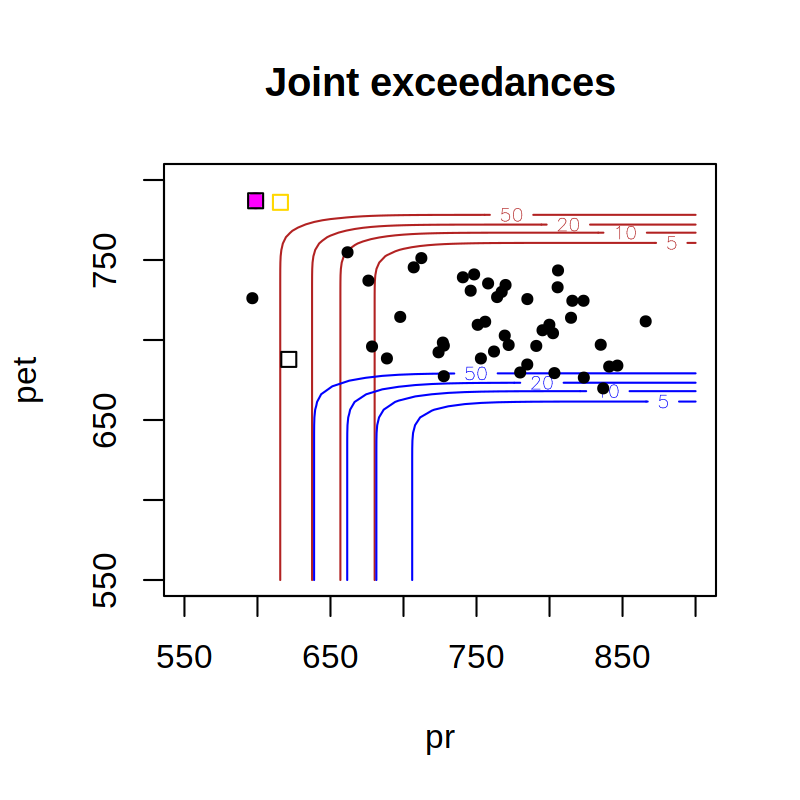

In [104]:
# check that plot region covers all contours & features of interest
prep_window(c(1,1))

contour(cmesh_2023, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "firebrick",
        main = "Joint exceedances", xlab = mdl_pr$varnm, ylab = mdl_pet$varnm)

contour(cmesh_hist, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "blue", add = T)

points(mdl_pr$x, mdl_pet$x, pch = 20)
points(mdl_pr$ev, mdl_pet$ev, pch = 20, col = "magenta", cex = 1.5)

points(rl_pr$"2023", rl_pet$"2023", pch = 0)
points(rl_pr$"hist", rl_pet$"hist", pch = 0)
points(rl_pr$"neut", rl_pet$"neut", pch = 0, col = "gold")

### **Save contours for transfer to python**

In [105]:
require(jsonlite)

contours <- list("coef" = coef(fitted_copula), 
                 "rl_pr" = rl_pr,
                 "rl_pet" = rl_pet,
                 "current" = cmesh_2023, 
                 "cf_hist" = cmesh_hist,
                 "joint_ep" = joint_ep)
write_json(contours, "joint-fit_mswx_pr-pet.json")

---
---
# **Plots used in paper**

In [15]:
source("../wwa_model-fitting.R")
source("../00_model-fitting-dev/multivariate/model-fitting_multi-covariate.R")

In [32]:
varnm = "spei"

gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
nino34 <- read.csv("ts/nino34_det.csv", col.names = c("year", "nino34"))
nino34$nino34 <- filter(nino34$nino34, rep(1/6,6), sides = 1)
nino34 <- nino34[substr(nino34$year,6,7) == "11",]
nino34$year <- substr(nino34$year,1,4)

gmst_2023 <- gmst$gmst[gmst$year == 2023]
nino_2023 <- nino34$nino34[nino34$year == 2023]

# gmst_cf <- mean(gmst$gmst[gmst$year >= 1980])
nino_cf <- mean(nino34$nino34[nino34$year >= 1980])

# fit NS model to all time series
models_withnino <- models_gmstonly <- list()
for (fnm in list.files("ts", pattern = paste0("cx_",varnm,"6.+.csv"), full.names = T)) {
    
    # extract all details from filename
    z <- strsplit(fnm, "_")[[1]][2]
    nm <- as.integer(gsub("[a-z]","",z))
    varnm <- gsub("[0-9]","",z)
    ds <- gsub(".csv","",strsplit(fnm,"_")[[1]][3])
    lt <- switch(varnm, "pet" = F, "spei" = T, "spi" = T)
    
    # load data & combine into single dataframe
    spi <- read.csv(fnm, col.names = c("year", "spi"))
    df <- merge(merge(spi, gmst), nino34)
    
    # fit model
    mdl_withnino <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino34"), lower = lt)
    mdl_gmstonly <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst"), lower = lt)
        
    models_withnino[[ds]] <- mdl_withnino
    models_gmstonly[[ds]] <- mdl_gmstonly
}
n <- length(models_withnino)

## **Trend with return periods**

In [33]:
prep_window(c(1,3))

ylims <- switch(varnm, "spei" = c(-4,2.5), "spi" = c(-6.5,3))

png(paste0("fig/",varnm,"-trend-with-return-periods.png"), height = 480 * 0.75, width = 480 * n); par(cex.main = 2, cex.axis = 1.4, cex.lab = 1.7); {
    par(mfrow = c(1,n), mar = c(3,4.5,3,1))
    for ( ds in names(models_withnino) ) {
    
        mdl_gmst <- models_gmstonly[[ds]]
        df <- mdl_gmst$data

        plot(df$year+0.5, df$spi, type = "S", lwd = 3, col = adjustcolor("black", 0.4), xlab = "", ylab = toupper(varnm), main = toupper(ds), ylim = ylims)
        lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

        lines(df$year, ns_pars(mdl_gmst)$loc, lwd = 3)
        lines(df$year, ns_pars(mdl_gmst, fixed_cov = data.frame(gmst = df$gmst))$loc, lwd = 2, col = "black") # GMST trend

        lines(df$year, eff_return_level(mdl_gmst, 6), lwd = 2, col = adjustcolor("black", 0.7), lty = 3)
        lines(df$year, eff_return_level(mdl_gmst, 40), lwd = 2, col = adjustcolor("black", 0.4), lty = 3)

        points(df[df$year == 2023,c("year", "spi")], pch = 21, bg = "magenta", cex = 2)

        abline(h = 0, lty = 2, lwd = 0.5)

        legend("bottomleft", legend = c("Mean", "1-in-6-year event", "1-in-40-year event"), col = mapply(adjustcolor, "black", c(1,0.7,0.4)), lty = c(1,3,3), lwd = c(3,2,2) , bty = "n", cex = 1.5)
    }
}; dev.off()

png 
  2

## **Return level plots**

In [34]:
# custom plotting for report
plot_returnlevels <- function(mdl, cov, cov_cf, ev, ylim = NA, pch = 20, ylab = NA, legend_pos = "topright", main = "", 
                              xlim = c(1,10000), legend_labels = c("Present climate", "Counterfactual climate"), seed = 42, nsamp = 500, ...) {
    
    x <- mdl$x
    if(missing(ev)) { ev <- mdl$ev }
    
    rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100), seq(1000,10000,1000)))     # return periods at which to calculate values for curves
    rp_th <- 1/seq(1,0,length.out = length(x)+2)[2:(length(x)+1)]                                                  # quantiles to map against observations to check fit

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # calculate return periods & return levels
    
    rl_curve_pres <- map_from_u(mdl, 1/rp_x, fixed_cov = cov)
    rl_curve_cf <- map_from_u(mdl, 1/rp_x, fixed_cov = cov_cf)

    rl_obs_pres <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov)
    rl_obs_cf <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov_cf)

    rp_event_pres <- 1/map_to_u(mdl, ev, fixed_cov = cov)
    rp_event_cf <- 1/map_to_u(mdl, ev, fixed_cov = cov_cf)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # prep axes
    
    if(is.na(ylim[1])) { ylim <- range(pretty(c(x, rl_curve_pres, rl_curve_cf))) }
    if(is.na(ylab)) {ylab <- mdl$varnm}
    # if((substr(mdl$varnm,1,3) == "log") & (ylim[1] <= 0)) { ylim[1] <- 0.01 }
    
    # plot
    plot(0,type = "n", xlim = xlim, ylim = ylim, log = "x", xlab = "", ylab = "", main = main)
    mtext("Return period (years)", side = 1, line = 2.5, cex = 1.3)
    mtext(ylab, side = 2, line = 2.5, cex = 1.3)
    
    legend(legend_pos, legend = c(legend_labels, "Observed event"), col = c("firebrick", "blue", "magenta"), lty = 1, pch = c(pch,pch,NA), bty = "n", cex = 2)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # return period curves
    lines(rp_x, rl_curve_pres, lwd = 2, col = "firebrick", lty = 1)       # present climate
    lines(rp_x, rl_curve_cf, lwd = 2, col = "blue", lty = 1)              # counterfactual
    
    # expected return periods vs return levels transformed to stationarity at that covariate value
    points(rp_th, sort(rl_obs_pres, decreasing = mdl$lower), col = "firebrick", pch = pch, cex = 2)      # present
    points(rp_th, sort(rl_obs_cf, decreasing = mdl$lower), col = "blue", pch = pch, cex = 2)             # counterfactual
    
    # horizontal line showing observed event, plus ticks showing return periods
    abline(h = ev, col = "magenta", lty = 2)
    suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))   # present
    suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))          # counterfactual
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Add confidence intervals to return periods
    
    if(!is.na(nsamp)) {
        x_ci <- c(5,10,20,50,100,200,500,1000,2000,5000,10000)
        set.seed(seed)

        mdl_df <- mdl$data[,c(mdl$varnm, mdl$covnm)]
        boot_res <- sapply(1:nsamp, function(i) {
            boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
            tryCatch({
                boot_mdl <- refit(mdl, boot_df)
                # print(boot_mdl$par)
                c(map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov), map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_cf))
            }, error = function(cond) {return(rep(NA, length(x_ci)*2))})
        })
        est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)
        
        # lines bounding confidence intervals
        # matplot(x_ci, t(est_ci[,1:length(x_ci)]), type = "l", lty = 1, lwd = 2, col = adjustcolor("firebrick", alpha = 0.3), add = T)
        # matplot(x_ci, t(est_ci[,-(1:length(x_ci))]), type = "l", lty = 1, lwd = 2, col = adjustcolor("blue", alpha = 0.3), add = T)
        
        # shaded region for confidence intervals
        polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,1:length(x_ci)], rev(est_ci[2,1:length(x_ci)])), density = NULL, border = NA, col = adjustcolor("firebrick", alpha = 0.1))
        polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,-(1:length(x_ci))], rev(est_ci[2,-(1:length(x_ci))])), density = NULL, border = NA, col = adjustcolor("blue", alpha = 0.1))
    }
}

In [35]:
prep_window(c(1,3))

ylims <- switch(varnm, "pet" = c(550,800), "spei" = c(-5,3), "spi" = c(-8,4))

png(paste0("fig/",varnm,"-return-levels.png"), height = 480 * 0.75, width = 480 * n); par(cex.main = 2, cex.axis = 1.8, cex.lab = 2); {
    par(mfrow = c(1,n), mar = c(4,4.5,3,1))
    for ( ds in names(models_withnino) ) {
    
        mdl_gmst <- models_gmstonly[[ds]]
        df <- mdl_gmst$data

        plot_returnlevels(mdl_gmst, cov = data.frame(gmst = gmst_2023), cov_cf = data.frame(gmst = gmst_2023 - 1.2), ylim = ylims, ylab = toupper(varnm), main = toupper(ds), cex = 1.4)
        abline(h = 0, lty = 2)
    }
}; dev.off()

png 
  2

## **Trend with & without ENSO**

In [26]:
prep_window(c(1,3))

n <- length(models_withnino)
ylims <- switch(varnm, "spei" = c(-4,2.5), "spi" = c(-6.5,3))

png(paste0("fig/",varnm,"-trend-with-and-without-nino.png"), height = 480 * 0.75, width = 480 * n); par(cex.main = 2, cex.axis = 1.4, cex.lab = 1.5); {
    par(mfrow = c(1,n), mar = c(3,4.5,3,1))
        for ( ds in names(models_withnino) ) {

        mdl_nino <- models_withnino[[ds]]
        mdl_gmst <- models_gmstonly[[ds]]
        df <- mdl_nino$data

        plot(df$year+0.5, df$spi, type = "S", lwd = 3, col = adjustcolor("black", 0.4), xlab = "", ylab = toupper(varnm), main = toupper(ds), ylim = ylims)
        # lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

        lines(df$year, ns_pars(mdl_gmst)$loc, lwd = 3)
        lines(df$year, ns_pars(mdl_gmst, fixed_cov = data.frame(gmst = df$gmst))$loc, lwd = 2, col = "black") # GMST trend

        lines(df$year, ns_pars(mdl_nino)$loc, lwd = 3, col = "darkred")
        lines(df$year, ns_pars(mdl_nino, fixed_cov = data.frame(gmst = df$gmst, nino34 = nino_cf))$loc, lwd = 3, lty = 2, col = "red3") # GMST trend when Nino is included

        points(df[df$year == 2023,c("year", "spi")], pch = 21, bg = "magenta", cex = 2)

        abline(h = 0, lty = 2, lwd = 0.5)
    }
}; dev.off()

png 
  2

## **Trend vs Nino**

In [55]:
prep_window(c(1,3))

n <- length(models_withnino)
ylims <- switch(varnm, "spei" = c(-4,2.5), "spi" = c(-6.5,3))

png(paste0("fig/",varnm,"-trend-vs-nino.png"), height = 480 * 0.75, width = 480 * n); par(cex.main = 2, cex.axis = 1.4, cex.lab = 1.7); {
    par(mfrow = c(1,n), mar = c(4.5,4.5,3,1))
    for ( ds in names(models_withnino) ) {
    
        mdl_nino <- models_withnino[[ds]]
        df <- mdl_nino$data
        df <- df[order(df$nino34),]
        
        gmst_cf <- mean(df$gmst)
        
        plot(df$nino34, df$spi,pch = 20, xlab = "Nino3.4", ylab = toupper(varnm), main = toupper(ds), ylim = ylims, cex = 1.7)
        lines(df$nino34, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

        lines(df$nino34, ns_pars(mdl_nino, fixed_cov = data.frame(gmst = gmst_cf, nino34 = df$nino34))$loc, lwd = 2, col = "black")

        abline(h = 0, v = 0, lty = 2, lwd = 0.5)
        points(df[df$year == 2023,c("nino34", "spi")], pch = 21, bg = "magenta", cex = 2)
        
        lines(df$nino34, eff_return_level(mdl_nino, 6, fixed_cov = data.frame(gmst = gmst_cf, nino34 = df$nino34)), lwd = 2, col = adjustcolor("black", 0.7), lty = 3)
        lines(df$nino34, eff_return_level(mdl_nino, 40, fixed_cov = data.frame(gmst = gmst_cf, nino34 = df$nino34)), lwd = 2, col = adjustcolor("black", 0.4), lty = 3)

        legend("bottomleft", legend = c("Mean", "1-in-6-year event", "1-in-40-year event"), col = mapply(adjustcolor, "black", c(1,0.7,0.4)), lty = c(1,3,3), lwd = c(3,2,2) , bty = "n", cex = 1.5)
    }
}; dev.off()

png 
  2

- What is the effect of excluding Nino3.4 on the uncertainty?